<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/93_Light_%D0%94%D0%97_%22%D0%93%D0%BE%D0%BB%D0%BE%D1%81%D0%B0_%D0%BF%D1%82%D0%B8%D1%86%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Напишите НС с использованием всех 6-ти параметризованных данных (частота цветности, мелкепстральные коэффициенты, спектральный центроид, ширина полосы частот, спектральный спад частоты, пересечение 0). 

Сравните её точность с точностью сети занятия (где использовалось 2 параметра при обучении - частота цветности и мелкепстральные коэффициенты). 

Выборку нужно использовать разделенную на фреймы по 4 секунды с шагом 4 секунды.

In [ ]:
# Устанавливем пакет librosa для работы с аудио
!pip install librosa==0.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201396 sha256=ed0482cf723adbe0f40435e944a075222a3cb7649aee6dcfd7fab90100567316
  Stored in directory: /root/.cache/pip/wheels/aa/5a/92/d52f6f8560ff05a2525e6030a1903412df876714241fb76802
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


In [ ]:
# Подключаем библиотеки
import sklearn
from IPython.display import Audio  # Воспроизведение аудиофайлов
import time                        # Для подсчёта времени 
import zipfile                     # Для разорхивации базы
import pandas as pd                # Для работы с табличными данными
from tensorflow.keras import utils # Для to_categorical
from google.colab import files     # Загрузка файлов
import os                          # Работа с папками и файлами
import librosa                     # Параметризация аудио
import librosa.feature             # Инструменты для параметризации
import numpy as np                 # Numpy массивы
import matplotlib.pyplot as plt    # Отображение графиков

# Отрисовка графиков в ячейках collab
%matplotlib inline 
from keras.optimizers import Adam, RMSprop # Оптимизатор для задания шага обучения
from keras.models import Sequential, Model # Два формата модели keras
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling1D, Reshape, Lambda, LeakyReLU # Базовые слови
from sklearn.model_selection import train_test_split # Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler # Для нормировки данных
# !!! Код не отработал!!!from keras.objectives import binary_crossentropy # Импортируем функцию потерь
from tensorflow.keras.losses import binary_crossentropy
# !!! Код не отработал!!! from keras.layers.advanced_activations import LeakyReLU # Импортируем функцию активации отдельным слоем
from keras import backend as K # Устанавливаем переменную для окружения кераса

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Разархивируем базу
bi = zipfile.ZipFile('/content/drive/MyDrive/Базы/база пения птиц. 88 классов.zip', 'r')
bi.extractall()

In [ ]:
# Загружаем данные
data = pd.read_csv('/content/birdsong_metadata.csv')

In [ ]:
# Выводим первые 10 строк 
data.head(10)

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
5,64686,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
6,120664,Acrocephalus,schoenobaenus,Sedge Warbler,david m,United Kingdom,56.5860,-6.1855,"male, song",http://creativecommons.org/licenses/by-nc-nd/3.0/
7,120666,Acrocephalus,schoenobaenus,Sedge Warbler,david m,United Kingdom,56.5860,-6.1855,"male, song",http://creativecommons.org/licenses/by-nc-nd/3.0/
8,76767,Acrocephalus,schoenobaenus,Sedge Warbler,Richard Dunn,United Kingdom,55.2809,-1.5801,song,http://creativecommons.org/licenses/by-nc-nd/2.5/
9,124052,Acrocephalus,scirpaceus,Eurasian Reed Warbler,david m,United Kingdom,51.8985,-0.5372,"call, female, male, song",http://creativecommons.org/licenses/by-nc-nd/3.0/


In [ ]:
# Посмотрим количество уникальных ID
data['file_id'].nunique()

264

In [ ]:
# Выведем все названия птиц
data.english_cname.unique()
bb = data.english_cname.unique()
bb

array(['Common Redpoll', 'Marsh Warbler', 'Sedge Warbler',
       'Eurasian Reed Warbler', 'Long-tailed Tit', 'Eurasian Skylark',
       'Meadow Pipit', 'Tree Pipit', 'Common Swift', 'Canada Goose',
       'Dunlin', 'European Nightjar', 'European Goldfinch',
       'Eurasian Treecreeper', 'European Greenfinch', 'Black-headed Gull',
       'Western Jackdaw', 'Rock Dove', 'Stock Dove', 'Common Wood Pigeon',
       'Northern Raven', 'Carrion Crow', 'Rook', 'Common Cuckoo',
       'Eurasian Blue Tit', 'Common House Martin',
       'Great Spotted Woodpecker', 'Black Woodpecker', 'Corn Bunting',
       'Yellowhammer', 'Common Reed Bunting', 'European Robin',
       'Common Chaffinch', 'Eurasian Coot', 'Common Snipe',
       'Common Moorhen', 'Eurasian Jay', 'Red-throated Loon',
       'Eurasian Oystercatcher', 'Barn Swallow', 'Eurasian Wryneck',
       'Willow Ptarmigan', 'European Herring Gull', 'Common Linnet',
       'River Warbler', 'Red Crossbill', 'Common Nightingale',
       'European

In [ ]:
# Создадим список названий птиц в соответствии с тем порядком, в котором они подгружаются
v=[]
for l in os.listdir(f'/content/songs/songs/'):
  songname = f'{l}'
  list(songname)
  a = int(songname[2:-5]) # Чтобы достать из названия файла только id
  for i in range(len(data['file_id'].values)):
    if a==data['file_id'].values[i]:
      v.append(i) # Составляем список id в том порядке, в котором загружаются файлы

birds1=[]
for j in v:
  birds1.append(data['english_cname'][j])

print(birds1)
print(len(birds1))

['Common Snipe', 'Eurasian Jay', 'Grey Partridge', 'Northern Lapwing', 'Common Reed Bunting', 'Black-headed Gull', 'Stock Dove', 'Common Wood Pigeon', 'Canada Goose', 'Dunlin', 'Goldcrest', 'Dunlin', 'Common Whitethroat', 'Wood Sandpiper', 'European Turtle Dove', 'Eurasian Wren', 'African Pied Wagtail', 'Sedge Warbler', 'Eurasian Collared Dove', 'Rock Dove', 'Red-throated Loon', 'Black-headed Gull', 'Eurasian Nuthatch', 'Eurasian Tree Sparrow', 'Coal Tit', 'Eurasian Wryneck', 'Willow Tit', 'Common Pheasant', 'Tree Pipit', 'Long-tailed Tit', 'Eurasian Bullfinch', 'European Bee-eater', 'Eurasian Golden Oriole', 'Long-tailed Tit', 'Great Tit', 'Wood Warbler', 'Common Starling', 'Common Blackbird', 'Lesser Whitethroat', 'Grey Plover', 'Common Wood Pigeon', 'Western Jackdaw', 'European Goldfinch', 'Marsh Tit', 'Great Spotted Woodpecker', 'Red-throated Loon', 'Common Starling', 'Tawny Owl', 'Sedge Warbler', 'Eurasian Magpie', 'European Turtle Dove', 'Great Spotted Woodpecker', 'Northern Lapw

In [ ]:
# Прослушаем пример записи
Audio(filename='/content/songs/songs/xc132611.flac')

In [ ]:
# Функция извлечения признаков: Частота цветности, Мел кепстральные коэффициенты, Спектральный центроид, Ширина полосы частот, Спектральный спад частоты, Пересечения нуля
def get_features(y, sr):

  '''
    get_features - функция параметризации данных
     y - временной ряд аудио
     sr - sampling rate(по умолчанию 22050) - частота дискретизации
  '''
  # Двумерные
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # Частота цветности
  mfcc = librosa.feature.mfcc(y=y, sr=sr)               # Мел кепстральные коэффициенты

  # Одномерные
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) # Спектральный центроид
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Ширина полосы частот
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)    # Спектральный спад частоты
  zcr = librosa.feature.zero_crossing_rate(y)               # Пересечения нуля

  # Возвращаем получившийся список
  return chroma_stft, mfcc, spec_cent, spec_bw, rolloff, zcr

# Вариант сети с длиной каждого фрейма 4 секунды и шагом 4 секунды

In [ ]:
from librosa.feature.spectral import chroma_stft
# Создаем пустые листы
X_train_1 = []
X_train_2 = []
X_train_3 = []
X_train_4 = []
X_train_5 = []
X_train_6 = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

i = 0
# Проходим по всем файлам папки
for filename in os.listdir(f'/content/songs/songs/'):
  songname = f'/content/songs/songs/{filename}'

  # Выделим из имени песни только число 
  songnum = f'{filename}'
  list(songnum)
  a = int(songnum[2:-5])

  # Следующая часть кода предназначена для того, чтобы присвоить каждой записи 
  # нужный цикл, а так как у нас по 3 записи каждой птицы и они загружаются 
  # вразноброс, мы делаем некую фильтрацию 264 записей по 88 классов (в соответствии с данными таблицы scv)

  # Пройдемся по всеим значениям столбца "file_id" и обнаружим текущую песню 
  for k in range(len(data['file_id'])):
    
    # Ищем сроку в данных/таблице, соответствующую текущей записи
    if a == data['file_id'][k]:

      # Вытаскиваем значение названия птицы для текущей записи
      w = data['english_cname'][k]

      # Проходимся циклом по нашим классам (88) и присваиваем в соответствии с записью 
      for t in range(len(bb)):
        if w == bb[t]:

          # Загружаем в аудиосигнал 
          y, sr = librosa.load(songname, mono=True)

          # Превращаем сигнал в параметризованные данные и раскусываем по 4 секунды с шагом 4 секунды
          for p in range(0, (int(len(y)//22050))-4, 4): # идем по длине временного ряда, от нуля до -4 (последний фрейм), с шагом 4

            chroma_stft, mfcc, spec_cent, spec_bw, rolloff, zcr = get_features(y[p*sr:(p+4)*sr], sr)

            # Добавляем строку в X_train
            X_train_1.append(chroma_stft)
            X_train_2.append(mfcc)
            X_train_3.append(spec_cent)
            X_train_4.append(spec_bw)
            X_train_5.append(rolloff)
            X_train_6.append(zcr)

            # Добавляем в Y_train номера классов в OHE
            Y_train.append(utils.to_categorical(t, len(bb)))

  # Выводим информацию о готовности бработки базы
  print(i, 'Птица ', birds1[i], 'готова -> ', round(time.time() - curr_time), 'c', sep='' )
  i+=1
  cur_time = time.time()

# Превращаем обучающую выборку в numpy массивы
X_train_1 = np.array(X_train_1)
X_train_2 = np.array(X_train_2)
X_train_3 = np.array(X_train_3)
X_train_4 = np.array(X_train_4)
X_train_5 = np.array(X_train_5)
X_train_6 = np.array(X_train_6)
Y_train = np.array(Y_train)

0Птица Common Snipeготова -> 3c
1Птица Eurasian Jayготова -> 6c
2Птица Grey Partridgeготова -> 7c
3Птица Northern Lapwingготова -> 9c
4Птица Common Reed Buntingготова -> 12c
5Птица Black-headed Gullготова -> 15c
6Птица Stock Doveготова -> 23c
7Птица Common Wood Pigeonготова -> 23c
8Птица Canada Gooseготова -> 26c
9Птица Dunlinготова -> 26c
10Птица Goldcrestготова -> 30c
11Птица Dunlinготова -> 30c
12Птица Common Whitethroatготова -> 36c
13Птица Wood Sandpiperготова -> 44c
14Птица European Turtle Doveготова -> 54c
15Птица Eurasian Wrenготова -> 59c
16Птица African Pied Wagtailготова -> 68c
17Птица Sedge Warblerготова -> 69c
18Птица Eurasian Collared Doveготова -> 73c
19Птица Rock Doveготова -> 74c
20Птица Red-throated Loonготова -> 78c
21Птица Black-headed Gullготова -> 86c
22Птица Eurasian Nuthatchготова -> 89c
23Птица Eurasian Tree Sparrowготова -> 94c
24Птица Coal Titготова -> 96c
25Птица Eurasian Wryneckготова -> 105c
26Птица Willow Titготова -> 109c
27Птица Common Pheasantготова ->

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


29Птица Long-tailed Titготова -> 114c
30Птица Eurasian Bullfinchготова -> 117c
31Птица European Bee-eaterготова -> 122c
32Птица Eurasian Golden Orioleготова -> 126c
33Птица Long-tailed Titготова -> 128c
34Птица Great Titготова -> 130c
35Птица Wood Warblerготова -> 134c
36Птица Common Starlingготова -> 136c
37Птица Common Blackbirdготова -> 139c
38Птица Lesser Whitethroatготова -> 140c
39Птица Grey Ploverготова -> 141c
40Птица Common Wood Pigeonготова -> 143c
41Птица Western Jackdawготова -> 143c
42Птица European Goldfinchготова -> 145c
43Птица Marsh Titготова -> 147c
44Птица Great Spotted Woodpeckerготова -> 148c
45Птица Red-throated Loonготова -> 167c
46Птица Common Starlingготова -> 182c
47Птица Tawny Owlготова -> 189c
48Птица Sedge Warblerготова -> 212c
49Птица Eurasian Magpieготова -> 213c
50Птица European Turtle Doveготова -> 215c
51Птица Great Spotted Woodpeckerготова -> 216c
52Птица Northern Lapwingготова -> 220c
53Птица Black Woodpeckerготова -> 222c
54Птица European Herring Gu

In [ ]:
# Выводим размеры обучающей выборки
print(X_train_1.shape)
print(X_train_2.shape)
print(X_train_3.shape)
print(X_train_4.shape)
print(X_train_5.shape)
print(X_train_6.shape)
print(Y_train.shape)

(4231, 12, 173)
(4231, 20, 173)
(4231, 1, 173)
(4231, 1, 173)
(4231, 1, 173)
(4231, 1, 173)
(4231, 88)


In [ ]:
def scale(X):
  '''
  scale() - функция для нормализации данных
  Х - данные, которые нужно нормализовать

  '''
  global min_X # делаем переменные глобальными, чтобы использовать при предсказании тестового файла
  global max_X # (используется, когда тестируем свою загруженную песню)
  min_X = X.min()
  max_X = X.max()

  X = (X - min_X) / (max_X - min_X)

  return X

In [ ]:
# Нормализуем тренировочные данные
X_train_1_scaled = scale(X_train_1)

# Xmin1 = min_X # запоминаем значения, чтобы потом использовать для предикта
# Xmax1 = max_X # запоминаем значения, чтобы потом использовать для предикта

X_train_2_scaled = scale(X_train_2)

# Xmin2 = min_X # запоминаем значения, чтобы потом использовать для предикта
# Xmax2 = max_X # запоминаем значения, чтобы потом использовать для предикта

X_train_3_scaled = scale(X_train_3)

# Xmin3 = min_X # запоминаем значения, чтобы потом использовать для предикта
# Xmax3 = max_X # запоминаем значения, чтобы потом использовать для предикта

X_train_4_scaled = scale(X_train_4)

# Xmin4 = min_X # запоминаем значения, чтобы потом использовать для предикта
# Xmax4 = max_X # запоминаем значения, чтобы потом использовать для предикта

X_train_5_scaled = scale(X_train_5)

# Xmin5 = min_X # запоминаем значения, чтобы потом использовать для предикта
# Xmax5 = max_X # запоминаем значения, чтобы потом использовать для предикта

X_train_6_scaled = scale(X_train_6)

# Xmin6 = min_X # запоминаем значения, чтобы потом использовать для предикта
# Xmax6 = max_X # запоминаем значения, чтобы потом использовать для предикта

# Иссл.№1. В НС подается 3 input'a ( 2 из низ как в уроке + третий это сконкатенированные данные)

In [ ]:
# Сконкатенируем массивы 3 - 6 для подачи отдельным входом
X_train_3_6_scaled = np.concatenate((X_train_3_scaled, X_train_4_scaled, X_train_5_scaled, X_train_6_scaled), axis=1)
X_train_3_6_scaled.shape

(4231, 4, 173)

In [ ]:
# Разделяем на трениовочную, проверочную и тестовую выборки 
mask = np.random.sample(X_train_3_6_scaled.shape[0]) 

# Cоздание обучающей выборки
train_mask = mask < 0.8

# Cоздание проверочной выборки
val_mask = (mask >= 0.8) & (mask <= 0.999)

# Cоздание тестовой выборки 
test_mask = (mask >= 0.999)

print(len(X_train_3_6_scaled[train_mask]))
print(len(X_train_3_6_scaled[val_mask]))
print(len(X_train_3_6_scaled[test_mask]))

3338
889
4


Epoch 1/30
67/67 [==============================] - 4s 35ms/step - loss: 3.9404 - accuracy: 0.1393 - val_loss: 7.1602 - val_accuracy: 0.0675
Epoch 2/30
67/67 [==============================] - 2s 28ms/step - loss: 2.9274 - accuracy: 0.3385 - val_loss: 6.6144 - val_accuracy: 0.0765
Epoch 3/30
67/67 [==============================] - 2s 29ms/step - loss: 2.3846 - accuracy: 0.4473 - val_loss: 4.8625 - val_accuracy: 0.1361
Epoch 4/30
67/67 [==============================] - 3s 45ms/step - loss: 2.0418 - accuracy: 0.5147 - val_loss: 3.6830 - val_accuracy: 0.2058
Epoch 5/30
67/67 [==============================] - 3s 39ms/step - loss: 1.6910 - accuracy: 0.5977 - val_loss: 2.9170 - val_accuracy: 0.3003
Epoch 6/30
67/67 [==============================] - 2s 28ms/step - loss: 1.5217 - accuracy: 0.6351 - val_loss: 2.3974 - val_accuracy: 0.4072
Epoch 7/30
67/67 [==============================] - 2s 28ms/step - loss: 1.3154 - accuracy: 0.6881 - val_loss: 1.8922 - val_accuracy: 0.5501
Epoch 8/30
67

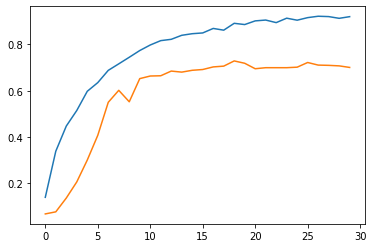

In [ ]:
# Создадим input'ы соответствующих данных
input_1 = Input((12, 173))
input_2 = Input((20, 173))
input_3 = Input((4, 173))

# Блок 1 "Частота цветности"
x1 = BatchNormalization()(input_1)
x1 = Flatten()(x1)

# Блок 2 "Мел кепстральные коэффициенты"
x2 = BatchNormalization()(input_2)
x2 = Flatten()(x2)

# Блок 3 "Спектральный центроид, Ширина полосы частот, Спектральный спад частоты, Пересечения нуля"
x3 = BatchNormalization()(input_3)
x3 = Flatten()(x3)

# Cоединяем данные всех блоков
x = concatenate([x1, x2, x3])

# В последнем слое 88 нейронов (по количеству классов)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(88, activation='softmax')(x)

model_simple = Model([input_1, input_2, input_3], x)

model_simple.compile(optimizer=Adam(learning_rate=1e-3),
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
history = model_simple.fit([X_train_1_scaled[train_mask], X_train_2_scaled[train_mask], X_train_3_6_scaled[train_mask]],
                           Y_train[train_mask],
                           epochs=30,
                           batch_size=50,
                           validation_data=([X_train_1_scaled[val_mask], X_train_2_scaled[val_mask], X_train_3_6_scaled[val_mask]],
                           Y_train[val_mask]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Иссл.№2. В НС подается 6 input'ов

Epoch 1/30
67/67 [==============================] - 6s 37ms/step - loss: 3.9238 - accuracy: 0.1486 - val_loss: 7.2682 - val_accuracy: 0.0641
Epoch 2/30
67/67 [==============================] - 3s 47ms/step - loss: 2.9026 - accuracy: 0.3322 - val_loss: 5.5166 - val_accuracy: 0.0866
Epoch 3/30
67/67 [==============================] - 2s 35ms/step - loss: 2.4150 - accuracy: 0.4407 - val_loss: 4.6310 - val_accuracy: 0.1282
Epoch 4/30
67/67 [==============================] - 2s 27ms/step - loss: 2.0377 - accuracy: 0.5138 - val_loss: 3.9740 - val_accuracy: 0.1485
Epoch 5/30
67/67 [==============================] - 2s 28ms/step - loss: 1.7384 - accuracy: 0.5824 - val_loss: 3.1450 - val_accuracy: 0.2621
Epoch 6/30
67/67 [==============================] - 2s 31ms/step - loss: 1.4830 - accuracy: 0.6456 - val_loss: 2.4071 - val_accuracy: 0.4252
Epoch 7/30
67/67 [==============================] - 2s 28ms/step - loss: 1.3085 - accuracy: 0.6827 - val_loss: 1.9001 - val_accuracy: 0.5647
Epoch 8/30
67

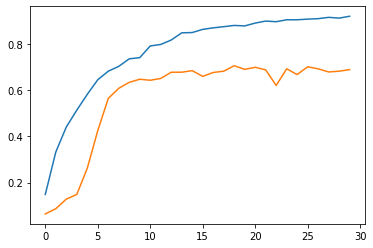

In [ ]:
# Создадим input'ы соответствующих данных
input_1 = Input((12, 173))
input_2 = Input((20, 173))
input_3 = Input((1, 173))
input_4 = Input((1, 173))
input_5 = Input((1, 173))
input_6 = Input((1, 173))

# Блок 1 "Частота цветности"
x1 = BatchNormalization()(input_1)
x1 = Flatten()(x1)

# Блок 2 "Мел кепстральные коэффициенты"
x2 = BatchNormalization()(input_2)
x2 = Flatten()(x2)

# Блок 3 "Спектральный центроид, Ширина полосы частот, Спектральный спад частоты, Пересечения нуля"
x3 = BatchNormalization()(input_3)
x3 = Flatten()(x3)

# Блок 4 "Ширина полосы частот"
x4 = BatchNormalization()(input_4)
x4 = Flatten()(x4)

# Блок 5 "Спектральный спад частоты"
x5 = BatchNormalization()(input_5)
x5 = Flatten()(x5)

# Блок 6 "Пересечения нуля"
x6 = BatchNormalization()(input_6)
x6 = Flatten()(x6)

# Cоединяем данные всех блоков
x = concatenate([x1, x2, x3, x4, x5, x6])

# В последнем слое 88 нейронов (по количеству классов)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(88, activation='softmax')(x)

model_simple = Model([input_1, input_2, input_3, input_4, input_5, input_6], x)

model_simple.compile(optimizer=Adam(learning_rate=1e-3),
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
history = model_simple.fit([X_train_1_scaled[train_mask], X_train_2_scaled[train_mask], X_train_3_scaled[train_mask], X_train_4_scaled[train_mask], X_train_5_scaled[train_mask], X_train_6_scaled[train_mask]],
                           Y_train[train_mask],
                           epochs=30,
                           batch_size=50,
                           validation_data=([X_train_1_scaled[val_mask], X_train_2_scaled[val_mask], X_train_3_scaled[val_mask], X_train_4_scaled[val_mask], X_train_5_scaled[val_mask], X_train_6_scaled[val_mask]],
                           Y_train[val_mask]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()